In [1491]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
import time as time
import os
import csv
from scipy.signal import butter, sosfilt
from scipy.signal import hilbert
import pandas as pd
from scipy.signal import argrelextrema

In [1492]:
from scipy.signal import savgol_filter

# Define Savitzky-Golay filter function
def savgol_filter_func(data, window_length, polyorder):
    return savgol_filter(data, window_length, polyorder)

In [2006]:
all_csv_data = pd.read_csv("../logs/exp_6_no_remove_cuff/Pico_data/exp_6_rachel_trial_circuit_5.txt",skiprows=1, sep='\s+').to_numpy()

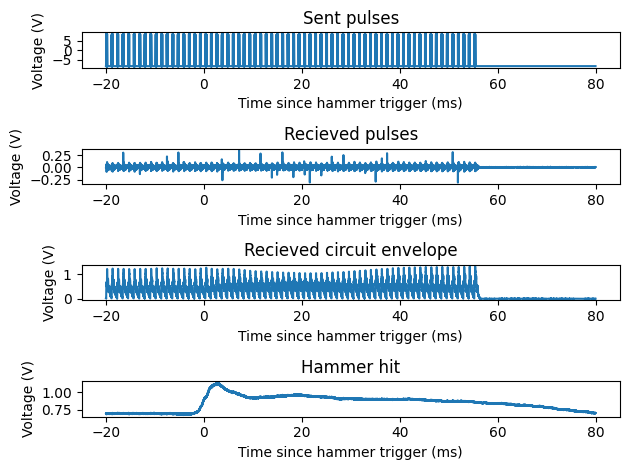

In [2007]:
csv_times = all_csv_data[:,0]
csv_square_pulses = all_csv_data[:,1]
csv_recieved_pulses = all_csv_data[:,2]
csv_circuit_envelope =  all_csv_data[:,3]
csv_hammer = all_csv_data[:,4]

plt.figure()
plt.subplot(4,1,1)
plt.plot(csv_times,csv_square_pulses)
plt.title("Sent pulses")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")

plt.subplot(4,1,2)
plt.plot(csv_times,csv_recieved_pulses)
plt.title("Recieved pulses")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")

plt.subplot(4,1,3)
plt.plot(csv_times,csv_circuit_envelope)
plt.title("Recieved circuit envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")

plt.subplot(4,1,4)
plt.plot(csv_times,csv_hammer)
plt.title("Hammer hit")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")

plt.subplots_adjust(hspace = 0.5)
plt.tight_layout()

Text(0, 0.5, 'Voltage (V)')

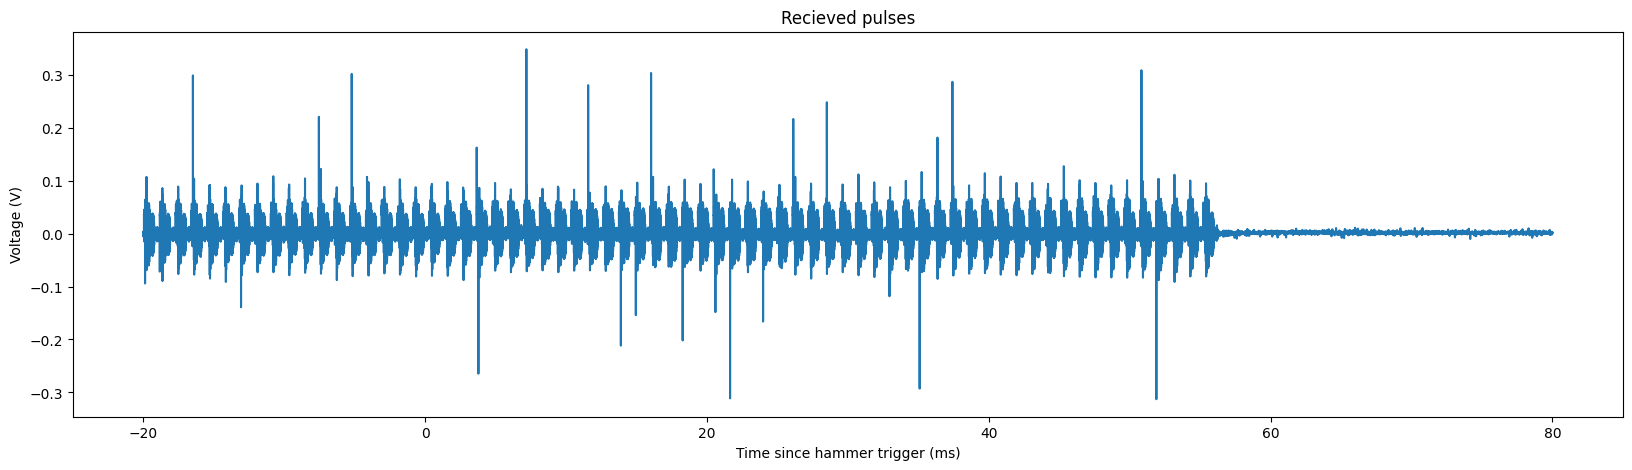

In [2008]:
plt.figure(figsize=(20,5))
plt.plot(csv_times,csv_recieved_pulses)
plt.title("Recieved pulses")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")

In [2009]:
from scipy.signal import find_peaks

def find_maxima_envelope(signal, sampling_rate, approx_frequency):
    """
    Find the envelope of a signal by identifying local maxima and connecting them with lines.

    Parameters:
    signal (numpy.ndarray): The input signal.
    sampling_rate (float): The sampling rate of the signal in Hz.
    approx_frequency (float): The approximate frequency of the signal in Hz.

    Returns:
    numpy.ndarray: The envelope of the input signal.
    """
    # Calculate the minimum distance between peaks in samples
    min_distance = int(sampling_rate / (approx_frequency/2))

    # Find the indices of the local maxima with the specified minimum distance
    peaks, _ = find_peaks(signal, distance=min_distance)

    # Get the values of the signal at the local maxima
    maxima = signal[peaks]

    # Interpolate between maxima to create the envelope
    envelope = np.interp(np.arange(len(signal)), peaks, maxima)

    return envelope


In [2010]:
from scipy.signal import medfilt

use_raw_envelope = False

filtered_recieved_pulses = []
calculated_envelope = []

if (use_raw_envelope):
    kernel_size = 3
    window_length = 30
    polyorder = 10
    filtered_recieved_pulses = medfilt(csv_recieved_pulses, kernel_size)
    # filtered_recieved_pulses = savgol_filter(csv_recieved_pulses, window_length, polyorder)

    lowest_freq_of_recieved_sig = 20000 # needs to be much lower than 52 kHz -- this is what determines the distance between points on the envelope
    osc_sampling_freq = 200000
    calculated_envelope = find_maxima_envelope(filtered_recieved_pulses, osc_sampling_freq, lowest_freq_of_recieved_sig)

else: 

    Filter_lowcut =40000
    Filter_highcut =60000
    Filter_order = 4
    Sampling_frequency=1000/(all_csv_data[1,0]-all_csv_data[0,0]) # in Hz, since time is in ms
    sos = butter(Filter_order, [Filter_lowcut, Filter_highcut], btype='bandpass', fs=Sampling_frequency, output='sos')


    filtered_recieved_pulses = np.apply_along_axis(lambda x: sosfilt(sos, x), axis=0, arr = csv_recieved_pulses)

    calculated_envelope = np.abs(hilbert(filtered_recieved_pulses, axis=0))


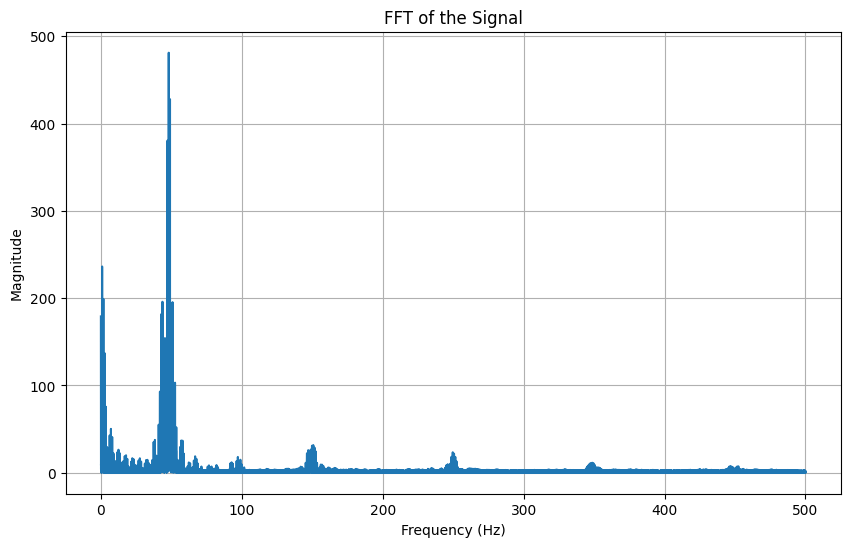

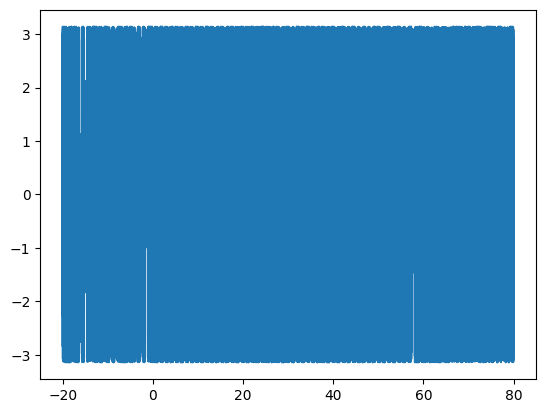

In [2011]:
# Quadrature modulation thing


# First, find the dominant frequency of the signal.
dt = np.mean(np.diff(csv_times))
fs = 1 / dt  # Sampling frequency

# Compute FFT
fft_values = np.fft.fft(csv_recieved_pulses)
fft_frequencies = np.fft.fftfreq(len(csv_recieved_pulses), dt)

# Only take the positive frequencies (and corresponding FFT values)
positive_frequencies = fft_frequencies[:len(fft_frequencies)//2]
positive_fft_values = fft_values[:len(fft_values)//2]

peak_frequency_index = np.argmax(np.abs(positive_fft_values))
peak_frequency = positive_frequencies[peak_frequency_index]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(positive_frequencies, np.abs(positive_fft_values))
plt.title('FFT of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()


recieved_freq = peak_frequency # in kHz
sin_ref = np.sin(csv_times*2*np.pi*recieved_freq) * filtered_recieved_pulses
cos_ref = np.cos(csv_times*2*np.pi*recieved_freq) * filtered_recieved_pulses


def convert_to_0_to_360(values):
    # Convert from radians to degrees
    degrees = np.degrees(values)
    # Wrap values to the range 0 to 360
    degrees = (degrees + 360) % 360
    return degrees

# phase_shift = np.arctan2(np.imag(hilbert(csv_recieved_pulses)), np.real(hilbert(csv_recieved_pulses))) # atan2(y, x) = arctan(y/x)
# phase_shift = np.sqrt(sin_ref*sin_ref*+cos_ref*cos_ref)
phase_shift = np.arctan2(sin_ref, cos_ref)
# phase_shift = np.unwrap(phase_shift) * 180.0/np.pi

plt.plot(csv_times, phase_shift)
# phase_shift = np.apply_along_axis(lambda x: sosfilt(sos, x), axis=0, arr = phase_shift)


Text(0.5, 0, 'Time since hammer trigger (ms)')

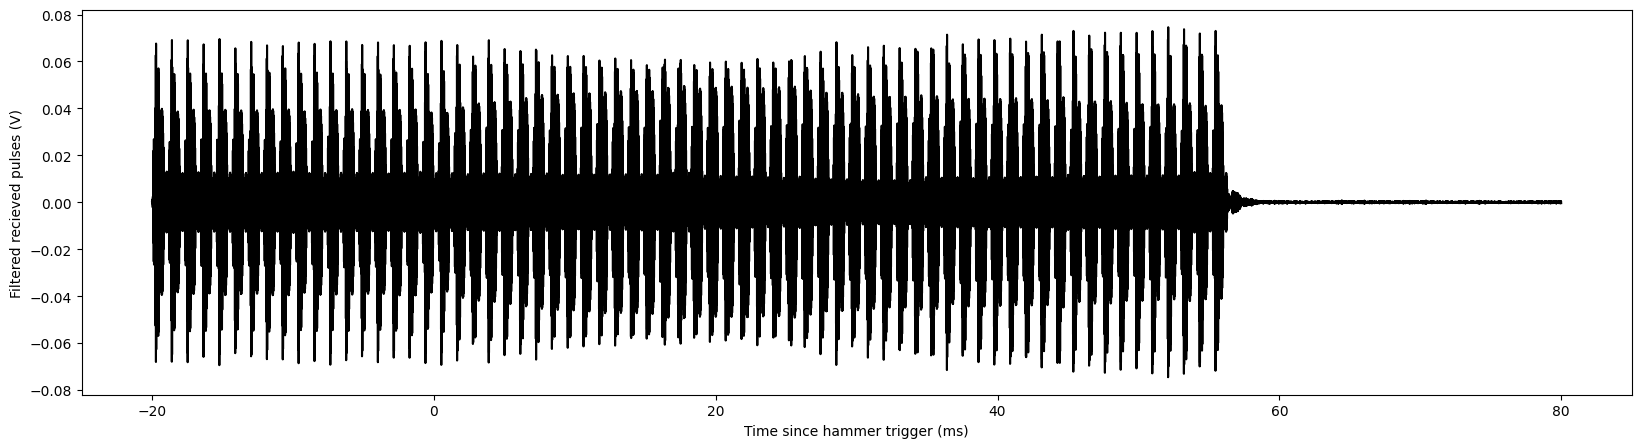

In [2012]:
plt.figure(figsize=(20,5))
plt.plot(csv_times,filtered_recieved_pulses,'k')
plt.ylabel('Filtered recieved pulses (V)')
plt.xlabel('Time since hammer trigger (ms)')

# plt.xlim((0,80))

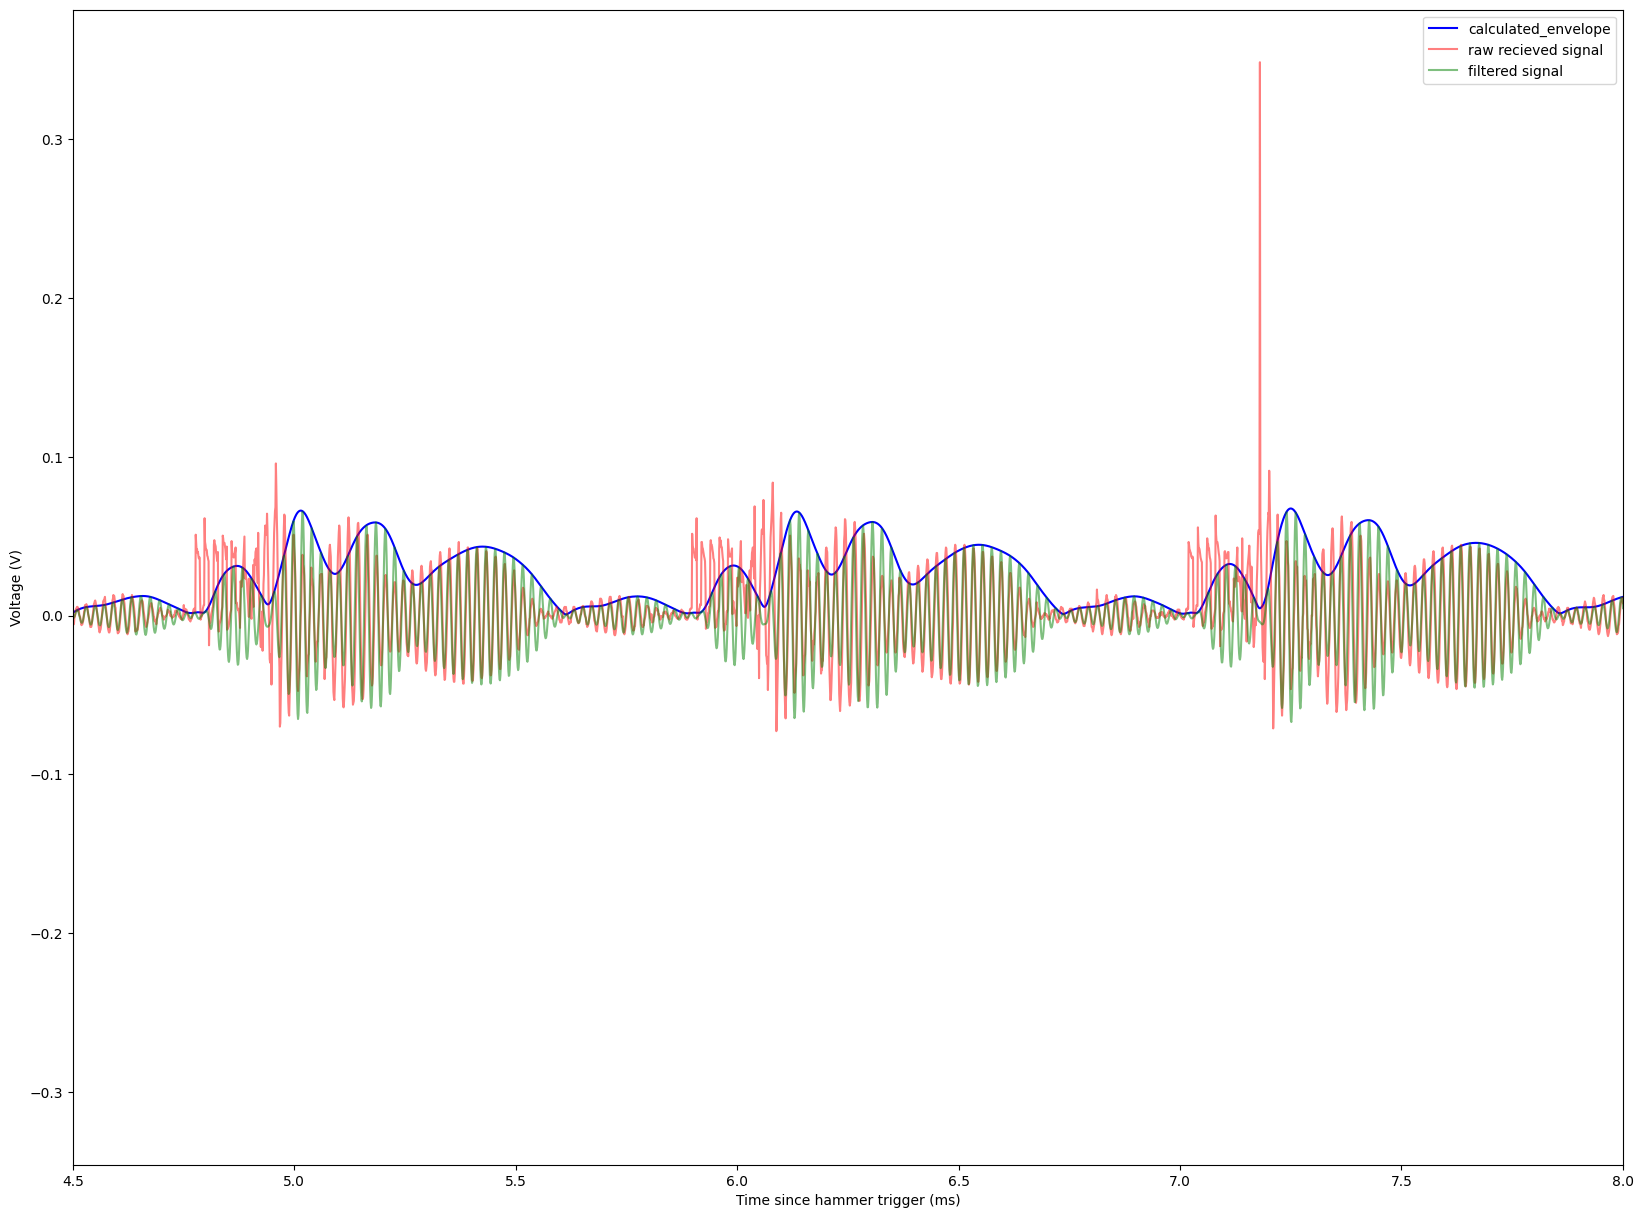

In [2013]:
plt.figure(figsize=(20,15))
plt.plot(csv_times, calculated_envelope, label="calculated_envelope", color = "blue")
plt.plot(csv_times, csv_recieved_pulses, label="raw recieved signal", color = "red", alpha = 0.5)
plt.plot(csv_times, filtered_recieved_pulses,label="filtered signal", color = "green", alpha = 0.5)
plt.ylabel('Voltage (V)')
plt.xlabel('Time since hammer trigger (ms)')
plt.xlim((4.5,8))
plt.legend()

(-11.0, 4.0)

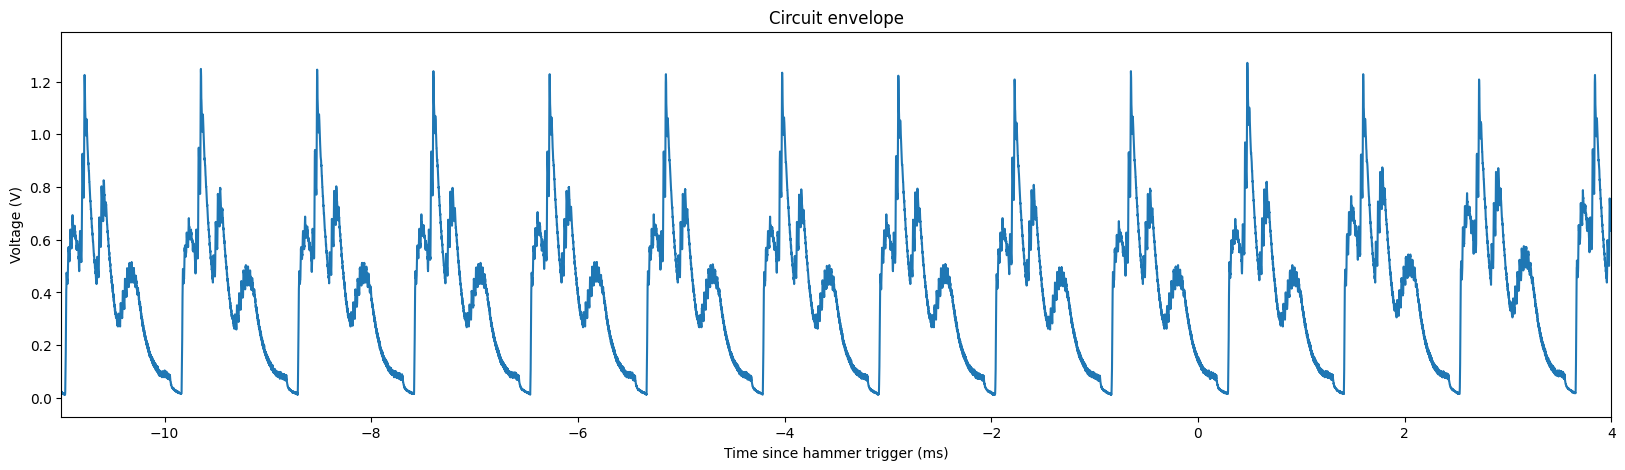

In [2014]:
plt.figure(figsize=(20,5))
plt.plot(csv_times,csv_circuit_envelope)
plt.title("Circuit envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((-11,4))

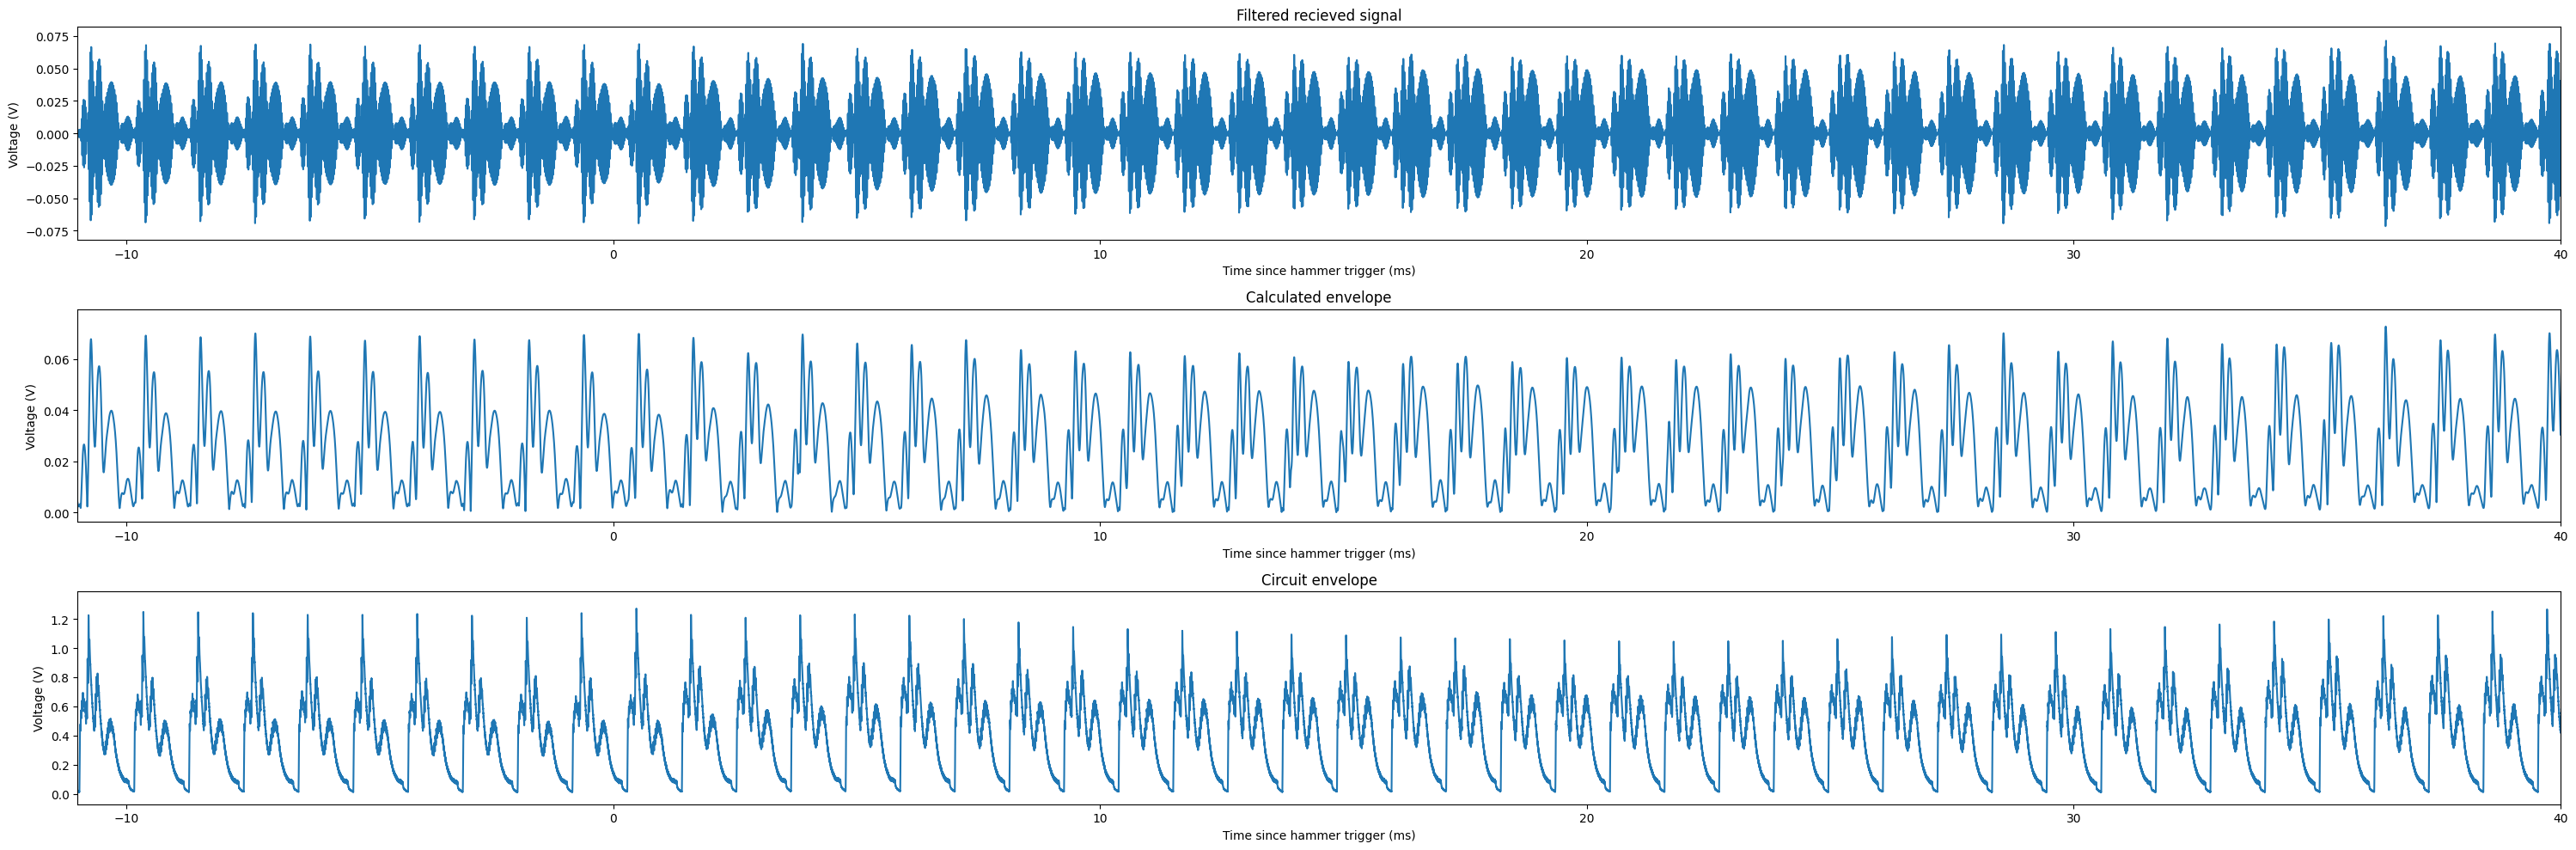

In [2015]:
min_time = -11
max_time = 40

plt.figure(figsize=(30,10))
plt.subplot(3,1,1)
plt.plot(csv_times,filtered_recieved_pulses)
plt.title("Filtered recieved signal")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.subplot(3,1,2)
plt.plot(csv_times,calculated_envelope)
plt.title("Calculated envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.subplot(3,1,3)
plt.plot(csv_times,csv_circuit_envelope)
plt.title("Circuit envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.subplots_adjust(hspace = 0.5)
plt.tight_layout()

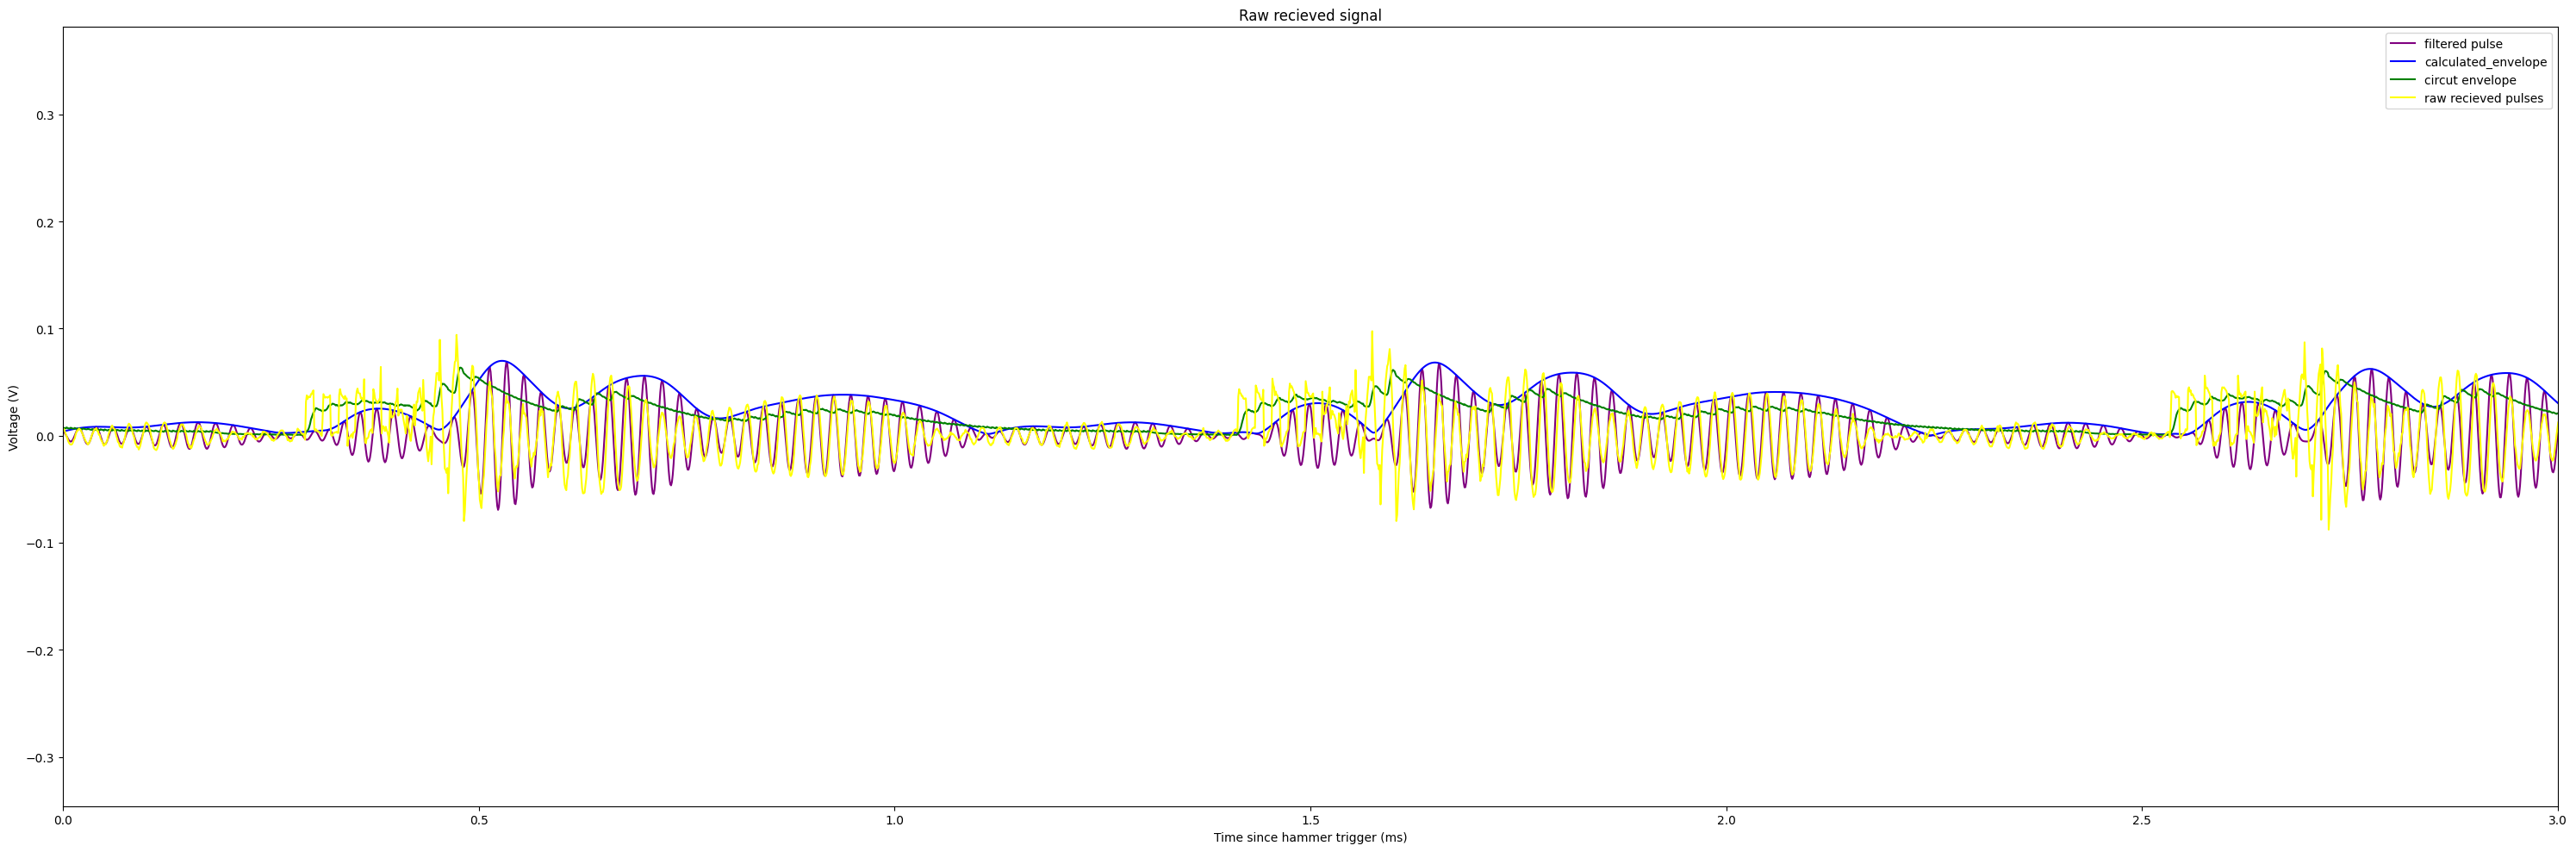

In [2016]:
min_time = 0
max_time = 3

plt.figure(figsize=(30,10))
plt.plot(csv_times,filtered_recieved_pulses, label="filtered pulse", color = "purple")
plt.title("Filtered recieved signal")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.plot(csv_times,calculated_envelope, label = "calculated_envelope", color = "blue")
plt.title("Calculated envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.plot(csv_times,csv_circuit_envelope * 1/20, label = "circut envelope", color = "green")
plt.title("Circuit envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.plot(csv_times,csv_recieved_pulses, label = "raw recieved pulses", color = "yellow")
plt.title("Raw recieved signal")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.subplots_adjust(hspace = 0.5)
plt.tight_layout()
plt.legend()

In [2017]:
################################ New reshaping code to account for big changes in periods btw pulses
NUM_PULSES = 0

### Find the start of each pulse
total_start_indicies =  []

i = 0
r = 0
tr = -7
max_pulse_length_in_indicies = 0
while i < (len(csv_square_pulses) - 1):
    if (csv_square_pulses[i] < tr and csv_square_pulses[i+1] >= tr):
        # print(f"{r}, {i}, {csv_square_pulses[i]}, {csv_square_pulses[i+1]}")
        total_start_indicies.append(i)
        if (r > 0):
            max_pulse_length_in_indicies = max(max_pulse_length_in_indicies, total_start_indicies[r] - total_start_indicies[r-1])
        r += 1
        i += 500
    i+=1
print(max_pulse_length_in_indicies)
NUM_PULSES = r

######## Reshaped arrays . shorter pulses padded with the last data point.
times_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
square_pulses_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
calculated_envelope_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
circuit_envelope_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
phase_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))

r = 0
for s in range(len(total_start_indicies)):
    this_start = total_start_indicies[s]
    next_start = len(csv_times) - 1
    if (s + 1 < len(total_start_indicies)): next_start = total_start_indicies[s+1]

    for c in range(max_pulse_length_in_indicies):
        if (c + this_start < next_start):
            times_reshaped[r][c] = csv_times[c + this_start]
            square_pulses_reshaped[r][c] = csv_square_pulses[c + this_start]
            calculated_envelope_reshaped[r][c] = calculated_envelope[c + this_start]
            circuit_envelope_reshaped[r][c] = csv_circuit_envelope[c + this_start]
            phase_reshaped[r][c] = phase_shift[c + this_start]
        else:
            times_reshaped[r][c] = csv_times[next_start - 1]
            square_pulses_reshaped[r][c] = csv_square_pulses[next_start - 1]
            calculated_envelope_reshaped[r][c] = calculated_envelope[next_start - 1]
            circuit_envelope_reshaped[r][c] = csv_circuit_envelope[next_start - 1]
            phase_reshaped[r][c] = phase_shift[next_start - 1]

    r += 1

start = np.zeros(NUM_PULSES)

''' 
# Sanity check that we are slicing the pulses correctly
for r in range(NUM_PULSES):
    fig = plt.figure(figsize =(10, 1))
    plt.plot(times_reshaped[r], circuit_envelope_reshaped[r])
    plt.show()
# '''


1127


' \n# Sanity check that we are slicing the pulses correctly\nfor r in range(NUM_PULSES):\n    fig = plt.figure(figsize =(10, 1))\n    plt.plot(times_reshaped[r], circuit_envelope_reshaped[r])\n    plt.show()\n# '

In [2018]:
points_per_col = max_pulse_length_in_indicies - 1

square_pulses_reshaped_cut = np.zeros((NUM_PULSES - 1,points_per_col))
calculated_envelope_reshaped_cut = np.zeros((NUM_PULSES - 1,points_per_col))
circuit_envelope_reshaped_cut = np.zeros((NUM_PULSES - 1,points_per_col))
time_ticks = []
    
for i in range(NUM_PULSES - 1):
    # For each pulse, only save certain columns (2000 data points after the start of the pulse burst)
    square_pulses_reshaped_cut[i,: ] = square_pulses_reshaped[i, start[i].astype(int) : start[i].astype(int) + points_per_col]
    calculated_envelope_reshaped_cut[i,:] = calculated_envelope_reshaped[i,start[i].astype(int):start[i].astype(int)+points_per_col]
    circuit_envelope_reshaped_cut[i,:] = circuit_envelope_reshaped[i,start[i].astype(int):start[i].astype(int)+points_per_col]
    time_ticks.append(round(times_reshaped[i, start[i].astype(int)], 2)) # Start time of each pulse


print(time_ticks)

[-19.96, -18.84, -17.71, -16.59, -15.46, -14.34, -13.21, -12.09, -10.96, -9.84, -8.71, -7.59, -6.46, -5.34, -4.21, -3.09, -1.96, -0.84, 0.29, 1.41, 2.53, 3.66, 4.78, 5.9, 7.02, 8.14, 9.26, 10.38, 11.5, 12.63, 13.75, 14.87, 15.99, 17.11, 18.23, 19.35, 20.48, 21.6, 22.72, 23.84, 24.96, 26.08, 27.2, 28.32, 29.45, 30.57, 31.69, 32.81, 33.93, 35.05, 36.17, 37.29, 38.42, 39.54, 40.66, 41.78, 42.9, 44.02, 45.14, 46.26, 47.39, 48.51, 49.63, 50.75, 51.87, 52.99, 54.11]


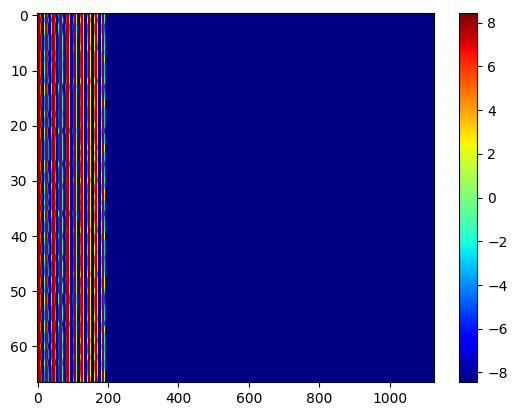

In [2019]:
plt.imshow( square_pulses_reshaped_cut, aspect='auto', cmap='jet')
plt.colorbar()

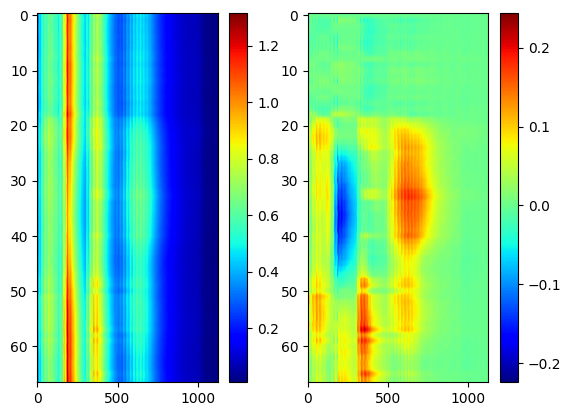

In [2020]:
plt.subplot(1,2,1)
plt.imshow(circuit_envelope_reshaped_cut, aspect='auto', cmap='jet')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(circuit_envelope_reshaped_cut-circuit_envelope_reshaped_cut[0,:], aspect='auto', cmap='jet')

plt.colorbar()


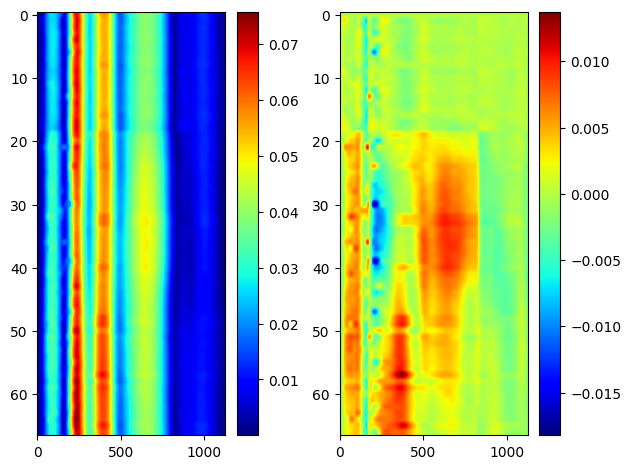

In [2021]:
plt.subplot(1,2,1)
plt.imshow(calculated_envelope_reshaped_cut, aspect='auto', cmap='jet')
plt.colorbar()
plt.subplot(1,2,2)

plt.imshow(calculated_envelope_reshaped_cut-calculated_envelope_reshaped_cut[0,:], aspect='auto', cmap='jet')
plt.colorbar()

plt.tight_layout()


In [2022]:
def find_outliers_iqr(data):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Calculate lower and upper boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    lower_outliers = data[data < lower_bound]
    upper_outliers = data[data > upper_bound]
    
    return lower_outliers, upper_outliers, lower_bound, upper_bound

def find_outliers_std(data, threshold=3):
    # Calculate the mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data)
    
    # Determine the lower and upper bounds
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
    
    # Find outliers
    lower_outliers = data[data < lower_bound]
    upper_outliers = data[data > upper_bound]
    
    return lower_outliers, upper_outliers, lower_bound, upper_bound

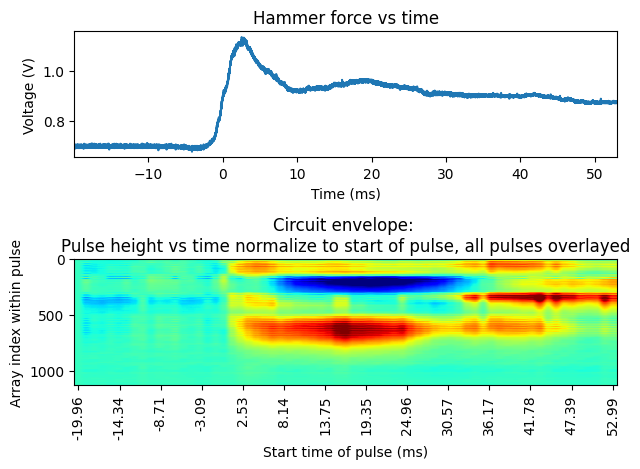

In [2023]:
plt.subplot(2,1,1)
plt.plot(csv_times,csv_hammer)
these_ticks = time_ticks[0::5]
plt.xlim(these_ticks[0], these_ticks[-1])
plt.title('Hammer force vs time')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (ms)')

plt.subplot(2,1,2)

new_arr = circuit_envelope_reshaped_cut-circuit_envelope_reshaped_cut[0,:]
#new_arr[0,0] = np.max(np.abs(new_arr))
#new_arr[0,1] = -1 * np.max(np.abs(new_arr))

# Set limits for imshow and plot
lower_outliers, upper_outliers, lower_lim_imshow, upper_lim_imshow = find_outliers_std(new_arr)
plt.imshow(np.transpose(new_arr), aspect='auto', cmap='jet', vmin = lower_lim_imshow, vmax = upper_lim_imshow)

time_tick_positions = np.arange(0, NUM_PULSES, NUM_PULSES/len(time_ticks))
plt.xticks(ticks = time_tick_positions[0::5], labels = time_ticks[0::5])
plt.xticks(rotation=90)
plt.title('Circuit envelope: \nPulse height vs time normalize to start of pulse, all pulses overlayed')
plt.ylabel('Array index within pulse')
plt.xlabel('Start time of pulse (ms)')

plt.tight_layout()

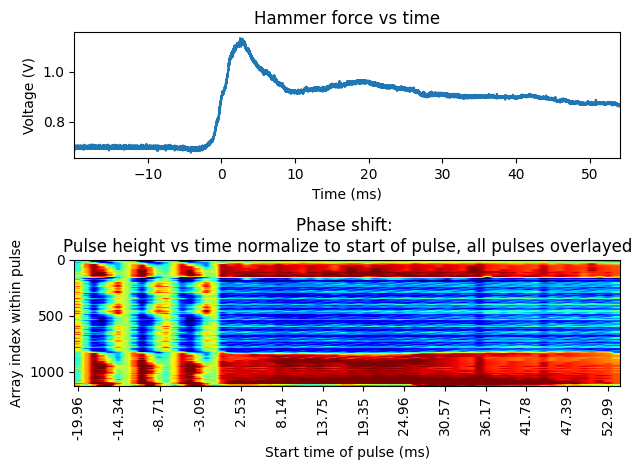

In [2033]:
plt.subplot(2,1,1)
plt.plot(csv_times,csv_hammer)
plt.xlim(time_ticks[0], time_ticks[-1])
plt.title('Hammer force vs time')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (ms)')

plt.subplot(2,1,2)

new_arr = phase_reshaped-phase_reshaped[6,:]
#new_arr[0,0] = np.max(np.abs(new_arr))
#new_arr[0,1] = -1 * np.max(np.abs(new_arr))

lower_outliers, upper_outliers, lower_lim_imshow, upper_lim_imshow = find_outliers_std(new_arr, 0.75)
plt.imshow(np.transpose(new_arr), aspect='auto', cmap='jet', vmin = lower_lim_imshow, vmax = upper_lim_imshow)

plt.title('Phase shift: \nPulse height vs time normalize to start of pulse, all pulses overlayed')
plt.ylabel('Array index within pulse')
plt.xlabel('Start time of pulse (ms)')

time_tick_positions = np.arange(0, NUM_PULSES, NUM_PULSES/len(time_ticks))
plt.xticks(ticks = time_tick_positions[0::5], labels = time_ticks[0::5])
plt.xticks(rotation=90)

plt.subplots_adjust(hspace = 0.5)
plt.tight_layout()

In [2034]:
''' 
# Sanity check that we are slicing the pulses correctly

for r in range(NUM_PULSES):
    if (r != 0):
        # last_angle = int(phase_reshaped[r-1][-1] / 360) * 360
        phase_reshaped[r] = phase_reshaped[r] - phase_reshaped[r][0]

for r in range(NUM_PULSES):
    fig = plt.figure(figsize =(15, 1))
    

    plt.plot(times_reshaped[r], phase_reshaped[r])
    plt.show()
# '''

' \n# Sanity check that we are slicing the pulses correctly\n\nfor r in range(NUM_PULSES):\n    if (r != 0):\n        # last_angle = int(phase_reshaped[r-1][-1] / 360) * 360\n        phase_reshaped[r] = phase_reshaped[r] - phase_reshaped[r][0]\n\nfor r in range(NUM_PULSES):\n    fig = plt.figure(figsize =(15, 1))\n    \n\n    plt.plot(times_reshaped[r], phase_reshaped[r])\n    plt.show()\n# '

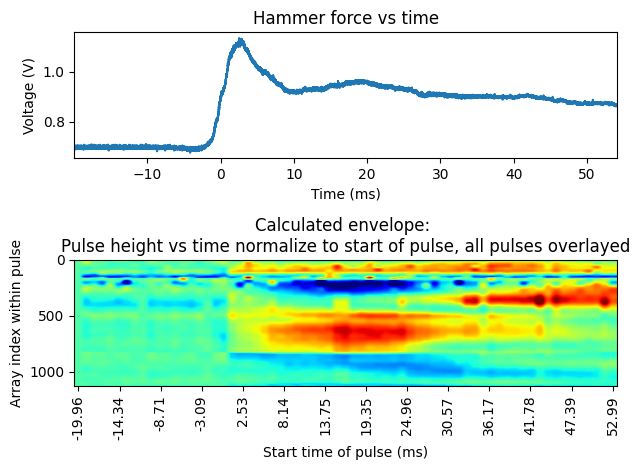

In [2035]:
plt.subplot(2,1,1)
plt.plot(csv_times,csv_hammer)
plt.xlim(time_ticks[0], time_ticks[-1])
plt.title('Hammer force vs time')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (ms)')

plt.subplot(2,1,2)

new_arr = calculated_envelope_reshaped_cut-calculated_envelope_reshaped_cut[0,:]
#new_arr[0,0] = np.max(np.abs(new_arr))
#new_arr[0,1] = -1 * np.max(np.abs(new_arr))

lower_outliers, upper_outliers, lower_lim_imshow, upper_lim_imshow = find_outliers_std(new_arr)
plt.imshow(np.transpose(new_arr), aspect='auto', cmap='jet', vmin = lower_lim_imshow, vmax = upper_lim_imshow)

plt.title('Calculated envelope: \nPulse height vs time normalize to start of pulse, all pulses overlayed')
plt.ylabel('Array index within pulse')
plt.xlabel('Start time of pulse (ms)')

time_tick_positions = np.arange(0, NUM_PULSES, NUM_PULSES/len(time_ticks))
plt.xticks(ticks = time_tick_positions[0::5], labels = time_ticks[0::5])
plt.xticks(rotation=90)

plt.subplots_adjust(hspace = 0.5)
plt.tight_layout()